# Lung Segmentation

In [1]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip

from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.10.0
Eager mode:  True
GPU is available


In [2]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape    # not in tensorflow.keras
from keras.layers.convolutional import Conv2D, Conv2DTranspose # not in tensorflow.keras
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D # not in tensorflow.keras
from keras.layers.merge import concatenate, add                # not in tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator # , array_to_img, img_to_array,load_img
from tensorflow.keras import backend as K
import joblib
import gc
import segmentation_models as sm

Segmentation Models: using `keras` framework.


* Extracting files here

In [3]:
# Read and examine metadata
# Note I had to usse '../filepath' instead of './filepath' because I work on a windows machine not a mac
raw_data = pd.read_csv('../input/covid19-ct-scans/metadata1.csv')
raw_data.head(5)

ct_scan  \
0  ../input/covid19-ct-scans/ct_scans/coronacases...   
1  ../input/covid19-ct-scans/ct_scans/coronacases...   
2  ../input/covid19-ct-scans/ct_scans/coronacases...   
3  ../input/covid19-ct-scans/ct_scans/coronacases...   
4  ../input/covid19-ct-scans/ct_scans/coronacases...   

                                           lung_mask  \
0  ../input/covid19-ct-scans/lung_mask/coronacase...   
1  ../input/covid19-ct-scans/lung_mask/coronacase...   
2  ../input/covid19-ct-scans/lung_mask/coronacase...   
3  ../input/covid19-ct-scans/lung_mask/coronacase...   
4  ../input/covid19-ct-scans/lung_mask/coronacase...   

                                      infection_mask  \
0  ../input/covid19-ct-scans/infection_mask/coron...   
1  ../input/covid19-ct-scans/infection_mask/coron...   
2  ../input/covid19-ct-scans/infection_mask/coron...   
3  ../input/covid19-ct-scans/infection_mask/coron...   
4  ../input/covid19-ct-scans/infection_mask/coron...   

                             lung_and_infection_mask  
0  ../input/covid19-ct-scans/lung_and_infection_m...  
1  ../input/covid19-ct-scans/lung_and_infection_m...  
2  ../input/covid19-ct-scans/lung_and_infection_m...  
3  ../input/covid19-ct-scans/lung_and_infection_m...  
4  ../input/covid19-ct-scans/lung_and_infection_m...

* img_size is the preferred image size to which the image is to be resized

In [4]:
img_size = 512

In [5]:
def clahe_enhancer(test_img, demo):
    '''* Used (CLAHE) Contrast Limited Adaptive Histogram Equalization to enhance the contrast of the images since medical images suffer a lot from the contrast problems.
    * Here Clip limit and the grid size are the hyperparameters to tune, generally clip limit should be between 2 to 4 as higher clip limit won't clip most of the histogram and treat it as AHE.
    * Higher clip limit might not even prevent the image from overamplifying the noise (the core advantage the CLAHE gives over AHE)
    * Demo is a boolean variable, if 1 then giving the ability to plot the before and image after enhancement along with their respective histogram plots.'''
    test_img = test_img*255
    test_img = np.uint8(test_img)
    test_img_flattened = test_img.flatten()

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(test_img)
    clahe_image_flattened = clahe_image.flatten()

    if demo == 1:

        fig = plt.figure()
        rcParams['figure.figsize'] = 10,10

        plt.subplot(2, 2, 1)
        plt.imshow(test_img, cmap='bone')
        plt.title("Original image")

        plt.subplot(2, 2, 2)
        plt.hist(test_img_flattened)
        plt.title("Histogram of Original Image")

        plt.subplot(2, 2, 3)
        plt.imshow(clahe_image, cmap='bone')
        plt.title("CLAHE Enhanced Image")

        plt.subplot(2, 2, 4)
        plt.hist(clahe_image_flattened)
        plt.title("Histogram of CLAHE Enhanced Image")

    return(clahe_image)

* Dataset contain 20 files of .nii type, though each file contained multiple channels or silces each as a separate gray scale image.
* Total slices are 3520. These have been sliced out by 10% in the front and by 10% in the last of each file since in general these didn't had any infection masks and some didn't had the lungs, removed as noise.
* Also, images had pixel values from -998 to 1000+. Did min-max scaling.

In [12]:
def read_nii_demo(filepath, data, img_size=512):
    '''
    Reads .nii file and returns pixel array which is was developed to read CT Scans.
    Takes in the file path and the data you wish to read.  Defines the image size to 
    be 512x512 by default but that can be changes with img_size=(desired size)
    '''
    # Get the image data loaded
    image = nib.load(filepath)
    array   = image.get_fdata()
    array   = np.rot90(np.array(array))
    
    # crop out the top and bottom 10%  This is done because the scans started above and continued below the lungs.
    slices = array.shape[2] 
    array = array[:,:,round(slices*0.1):round(slices*0.9)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1], 1))

    # Applies the reshaping of the image at each layer
    for img_no in range(0, array.shape[0]):
        # array = Image.resize(array[...,img_no], (img_size,img_size))
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        data.append(img)

In [9]:
image = nib.load('../input/covid19-ct-scans/ct_scans/coronacases_org_001.nii', )
print(image)
array   = image.get_fdata()
print('Original shape:', array.shape)
array   = np.rot90(np.array(array))
print('Shape after rotating 90 degrees: ',array.shape)
slices = array.shape[2] 
print('number of slices: ',slices)
array = array[:,:,round(slices*0.1):round(slices*0.9)]
print('Shape after removing top and bottom 10%: ',array.shape)
array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1], 1))
print('Final shape after rolling axis and reshaping: ',array.shape)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 301)
affine: 
[[  -0.81054699    0.            0.          213.10714722]
 [  -0.            0.81054699    0.         -206.89215088]
 [   0.           -0.            1.         -220.05334473]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512 301   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.        0.810547  0.810547  1.        1.        1.        1.
  1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.

In [13]:
cts = []
lungs = []
# infections=[] The infection mask could be used to determine lung disease but I'm currious what would happen if we skipped this

In [14]:
for i in range(0, 20):
    read_nii_demo(raw_data.loc[i,'lung_mask'], lungs)
    read_nii_demo(raw_data.loc[i,'ct_scan'], cts) 
    #read_nii_demo(raw_data.loc[i,'infection_mask'], infections) 

C:\ProgramData\Anaconda3\envs\Covid_19_X_Rays\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [15]:
print('cts',len(cts),np.shape(cts))
print('lungs',len(lungs),np.shape(lungs))
#print('infections',len(infections),np.shape(infections))

cts 2816 (2816, 512, 512)
lungs 2816 (2816, 512, 512)


In [16]:
def read_nii_transpose(filepath, data, img_size=512):
    '''
    Reads .nii file and returns pixel array which is was developed to read CT Scans.
    Takes in the file path and the data you wish to read.  Defines the image size to 
    be 512x512 by default but that can be changes with img_size=(desired size)
    '''
    # Get the image data loaded
    image = nib.load(filepath)
    array   = image.get_fdata()
    array   = np.rot90(np.array(array))
    
    # crop out the top and bottom 10%  This is done because the scans started above and continued below the lungs.
    slices = array.shape[2] 
    array = array[:,:,round(slices*0.1):round(slices*0.9)]
    array = np.transpose(array)

    # Applies the reshaping of the image at each layer
    for img_no in range(0, array.shape[0]):
        # array = Image.resize(array[...,img_no], (img_size,img_size))
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        data.append(img)

In [17]:
cts_T = []
lungs_T = []
# infections_T=[] The infection mask could be used to determine lung disease but I'm currious what would happen if we skipped this
for i in range(0, 20):
    read_nii_transpose(raw_data.loc[i,'lung_mask'], lungs_T)
    read_nii_transpose(raw_data.loc[i,'ct_scan'], cts_T) 
    #read_nii_transpose(raw_data.loc[i,'infection_mask'], infections) 
print('cts_transposed',len(cts_T),np.shape(cts_T))
print('lungs_transposed',len(lungs_T),np.shape(lungs_T))
#print('infections_transposed',len(infections_T),np.shape(infections_T))

C:\ProgramData\Anaconda3\envs\Covid_19_X_Rays\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


cts_transposed 2816 (2816, 512, 512)
lungs_transposed 2816 (2816, 512, 512)


* this part takes a while to do

In [18]:
import gc
gc.collect()

240

### Taking a look at some of the files

In [27]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[2], alpha=0.5, cmap='bone')
    plt.title('Transposed image')

    plt.subplot(1,4,4)
    plt.imshow(array_list[2], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.title('Transposed Lung Mask')

    plt.show()

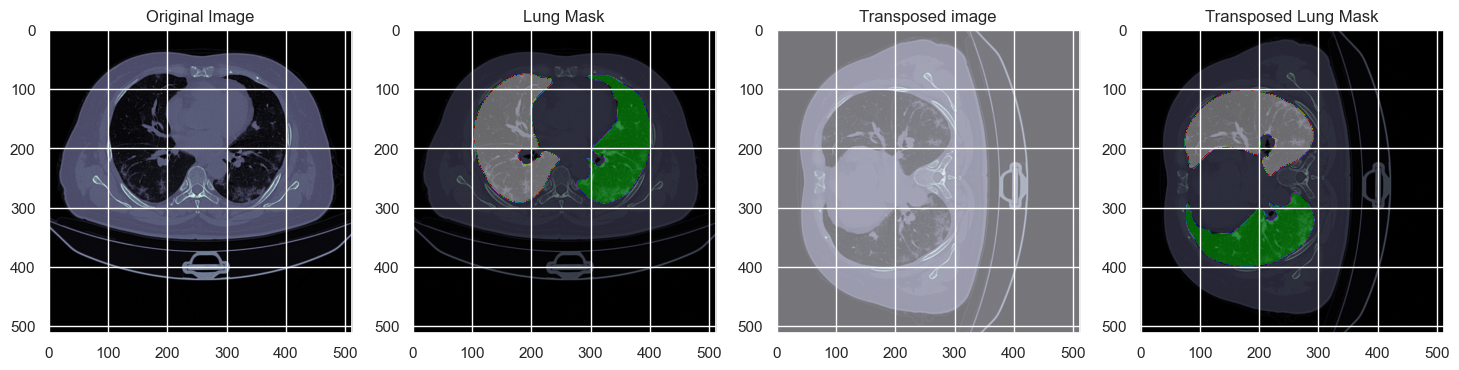

In [28]:
plot_sample([cts[120], lungs[120], cts_T[120], lungs_T[120]])

* This is why Deadskull7 did that fancy rollaxis it appears.  He wanted to get the data in the right orientation.

In [29]:
def read_nii_clahe(filepath, data, img_size=512):
    '''
    Reads .nii file and returns pixel array which is was developed to read CT Scans. 
    This also reshapes the data into (Z,X,Y,1) format from (X,Y,Z) and applies
    our CLAHE method to cleaning up the data
    '''
    # Get the image data loaded
    image = nib.load(filepath)
    array   = image.get_fdata()
    array   = np.rot90(np.array(array))
    
    # crop out the top and bottom 10%  This is done because the scans started above and continued below the lungs.
    slices = array.shape[2] 
    array = array[:,:,round(slices*0.1):round(slices*0.9)]
    # Rollaxis takes the last axis (slice or Z), and puts it in front of X and Y.  This reshapes the data into the proper format
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1], 1))
    
    # resize the image to what ever the prefered size would be default is 512
    for img_no in range(0, array.shape[0]):
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        
    # apply the CLAHE enhancer to each layer of the images
        if img_no < len(img):
            img = clahe_enhancer(img, demo = 0)
            
        data.append(img)

In [30]:
cts_clahe=[]
lungs_clahe=[]
#infections_clahe=[]

In [31]:
for i in range(0, 20):
    read_nii_clahe(raw_data.loc[i,'lung_mask'], lungs_clahe)
    read_nii_clahe(raw_data.loc[i,'ct_scan'], cts_clahe) 
    #read_nii_clahe(raw_data.loc[i,'infection_mask'], infections_clahe) 

C:\ProgramData\Anaconda3\envs\Covid_19_X_Rays\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [32]:
print('cts',len(cts_clahe),np.shape(cts_clahe))
print('lungs',len(lungs_clahe),np.shape(lungs_clahe))
#print('infections',len(infections_clahe),np.shape(infections_clahe))

cts 2816 (2816, 512, 512)
lungs 2816 (2816, 512, 512)


In [33]:
gc.collect()

11801

# First we will just clean up the images to do data analysis on.

In [34]:
clean_cts = []
clean_lungs = []

In [35]:
def clean_stack(array):
    ''' CLAHE a stack of images.'''
    new_array=[]

    for img_no in range(len(array)):
        #CLAHE the image
        cts_img = array[img_no]
        cts_img = clahe_enhancer(cts_img, demo = 0)
        new_array.append(cts_img)
    return new_array

In [36]:
clean_cts=clean_stack(cts)
clean_lungs=clean_stack(lungs) # is there a point to this?

In [37]:
print(np.shape(clean_cts))

(2816, 512, 512)


* Some of the images have no lung mask.
* We can find out which ones and remove them so our neural netowrk has a better ground truth on where the lungs are in the images

In [21]:
no_masks = []
for i in range(0, len(lungs)):
    if np.unique(lungs[i]).size == 1:
        no_masks.append(i)
print("Number of complete black masks :" , len(no_masks))
print("They are...",no_masks)

Number of complete black masks : 83
They are... [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 2570, 2571, 2572, 2573, 2574, 2575]


In [22]:
print("There are ",len(no_masks)," images with completely black masks.  I'll need to delete them to have things work.")

There are  83  images with completely black masks.  I'll need to delete them to have things work.


In [23]:
no_masks.reverse()
print(no_masks)

[2575, 2574, 2573, 2572, 2571, 2570, 1857, 1856, 1855, 1854, 1853, 1852, 1851, 1850, 1849, 1848, 1847, 1846, 1845, 1844, 1843, 1842, 1841, 1840, 1839, 1838, 1837, 1836, 1835, 1834, 1833, 1832, 1831, 1830, 1829, 1828, 1827, 1826, 1825, 1824, 1823, 1822, 1821, 420, 419, 418, 417, 416, 415, 414, 413, 412, 411, 410, 409, 408, 407, 406, 405, 404, 403, 402, 401, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


In [24]:
# Lets take a look at these and images and see what we have
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.show()

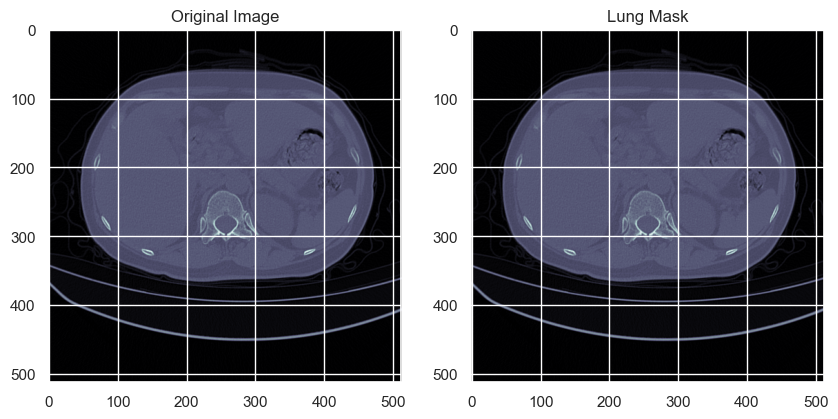

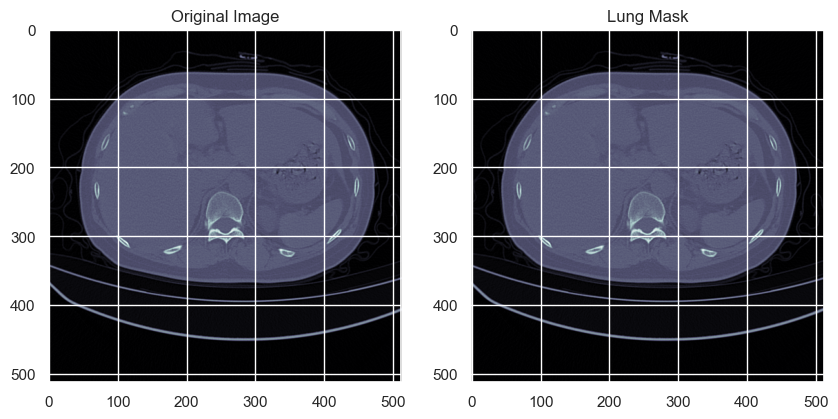

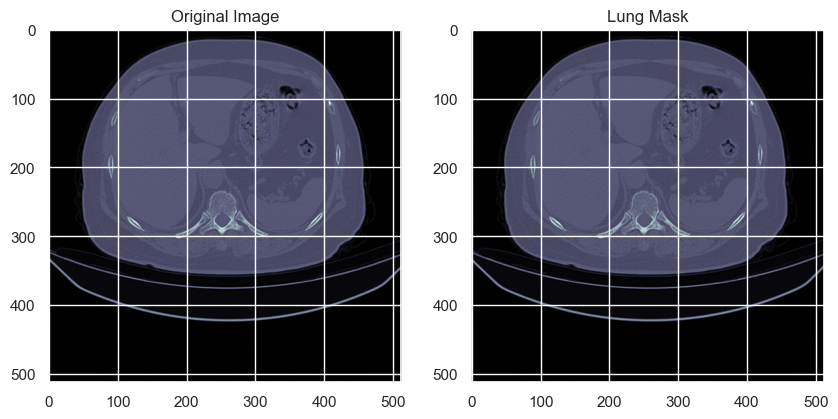

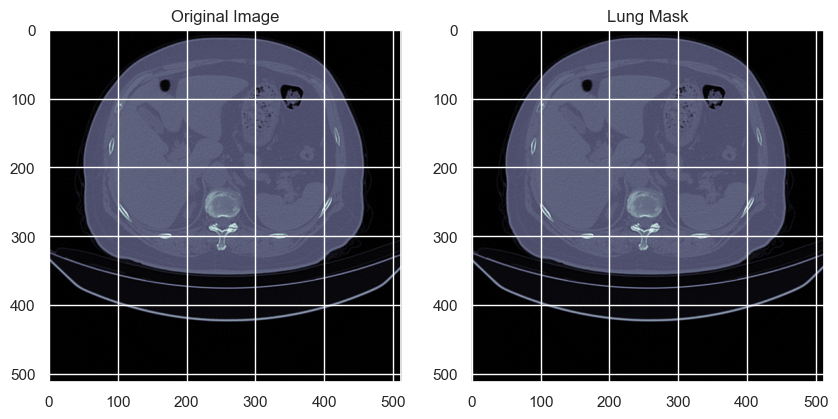

In [25]:
from random import sample
no_masks_sample=sample(no_masks,4)
for index in no_masks_sample:
    plot_sample([cts[index], lungs[index]])

* Clearly these images don't have any lungs in them and should be omitted from the pipeline
* On the other hand if we remove them for training what happens when our model encounters an image with no lung?

In [26]:
gc.collect()

23326

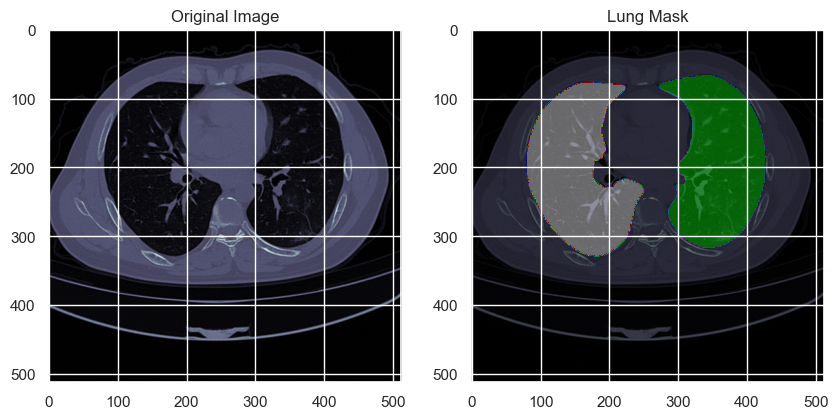

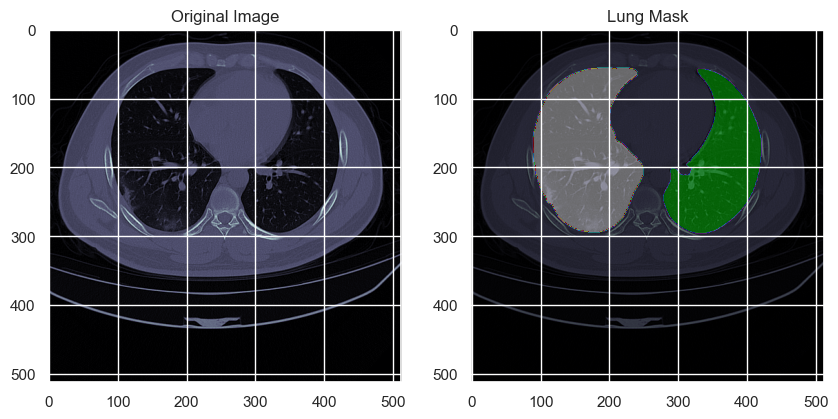

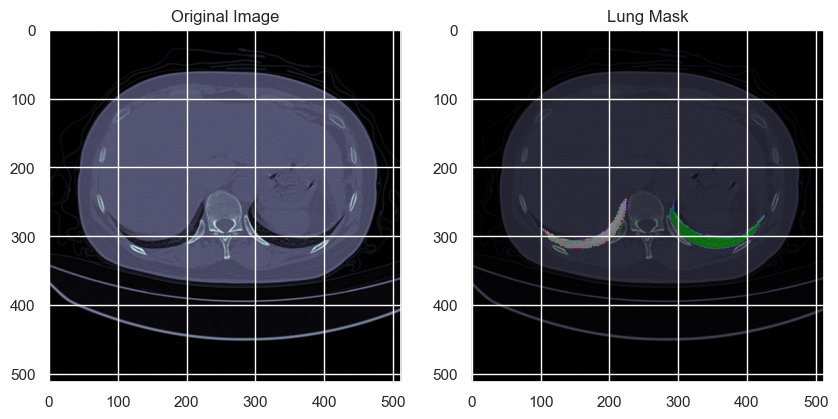

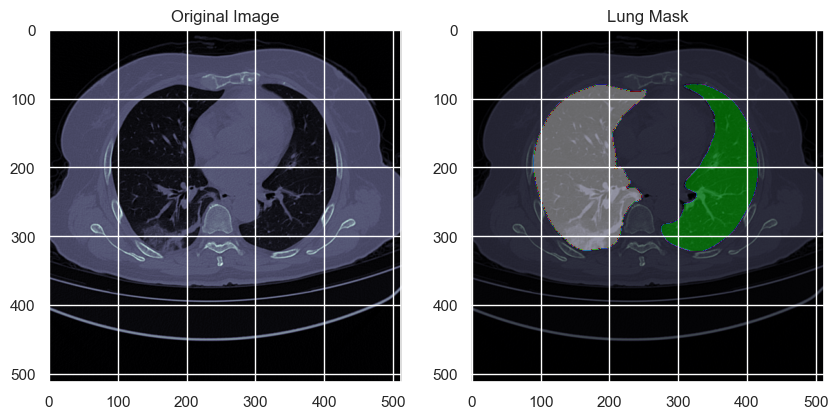

In [27]:
cts_sample=sample(range(len(cts)),4)
for index in cts_sample:
    plot_sample([cts[index], lungs[index]])

In [28]:
gc.collect()

23315

In [29]:
# so we don't delete the current dat we'll make a copy of it.
mask_cts=cts.copy()
mask_lungs=lungs.copy()
#mask_infections=infections.copy()

In [30]:
# removing the images w/o lung masks
for n in no_masks:
    del(mask_cts[n])
    del(mask_lungs[n])
    #del(mask_infections[n])

In [31]:
print(len(mask_cts))
print(len(mask_lungs))
#print(len(infections))

2733
2733


In [32]:
no_masks = []
for i in range(0, len(mask_lungs)):
    if np.unique(mask_lungs[i]).size == 1:
        no_masks.append(i)
print("Number of complete black masks :" , len(no_masks))

Number of complete black masks : 0


* Removing the empty masks seems to fix things.
* Furture feature: we can try to make this skip a slice if there is no mask.

In [33]:
print(np.shape(clean_cts))
print(np.shape(mask_cts))

(2816, 512, 512)
(2733, 512, 512)


In [34]:
# Lets make a copy of the data and try a different way of reshaping the data
cts_3D=cts.copy()
lungs_3D=lungs.copy()
#infecions_3D=infections.copy()

In [35]:
new_dim = 256
for i in range(0,len(cts)):
    cts_3D[i] = cv2.resize(cts_3D[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
    #cts_3D[i] = cts_3D[i]/255
    lungs_3D[i] = cv2.resize(lungs_3D[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
    #lungs_3D[i] = lungs_3D[i]/255
    #infections_3D[i] = cv2.resize(infections_3D[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
    #infections_3D[i] = infections_3D[i]/255

In [36]:
# Converting these into an array
cts_3D = np.array(cts_3D, dtype='object')
lungs_3D = np.array(lungs_3D, dtype='object')
#infections_3D = np.array(infections_3D, dtype='object')

In [37]:
print(cts_3D.shape)
print(lungs_3D.shape)
#print(infections_3D.shape)

(2816, 256, 256)
(2816, 256, 256)


In [38]:
print(cts_3D[0].shape)
print(lungs_3D[0].shape)
#print(infections_3D[0].shape)

(256, 256)
(256, 256)


This didn't work at all...

I was hoping to get the data into 1D format so it would be (2816,)

* since we did that on the original cts file we need to clean it with the CLAHE method again.

In [39]:
new_cts = []
new_lungs = []

In [40]:
new_cts=clean_stack(cts)
new_lungs=clean_stack(lungs) # is there a point to this?

In [41]:
gc.collect()

299

## Viewing our progress

(512, 512) (512, 512)


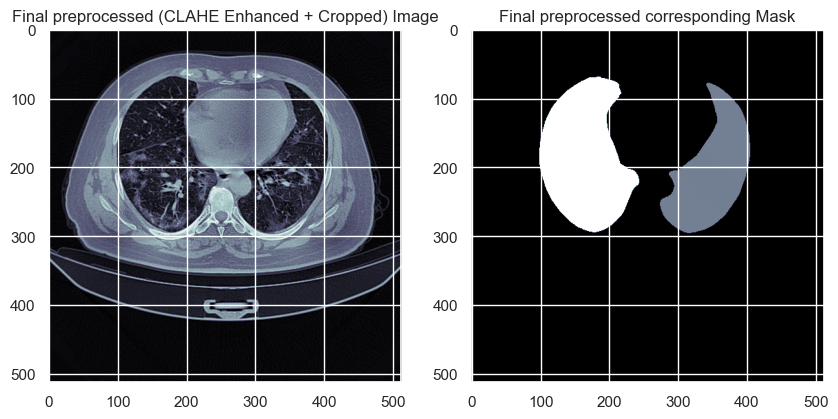

In [42]:
x = 100

rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(new_cts[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

plt.subplot(1, 2, 2)
plt.imshow(new_lungs[x], cmap='bone')
plt.title("Final preprocessed corresponding Mask")

print(new_cts[x].shape, new_lungs[x].shape)

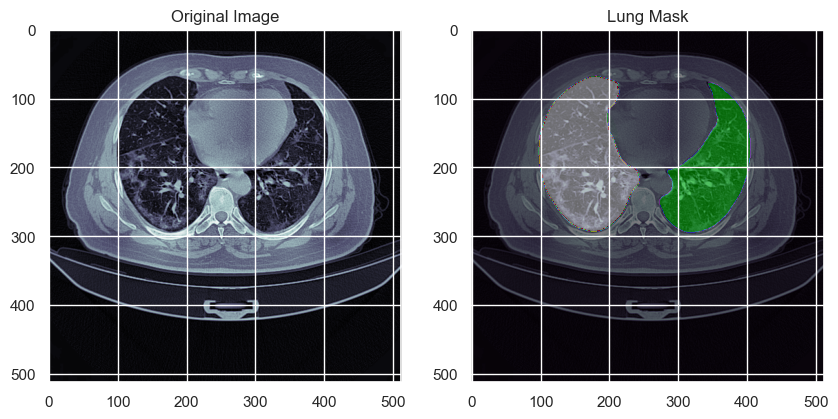

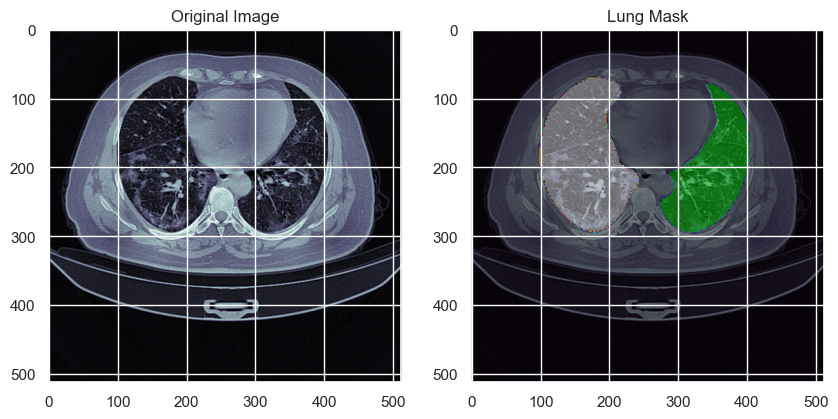

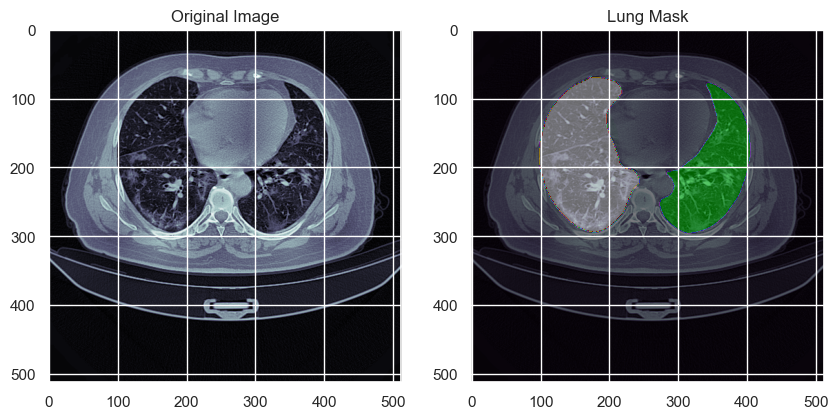

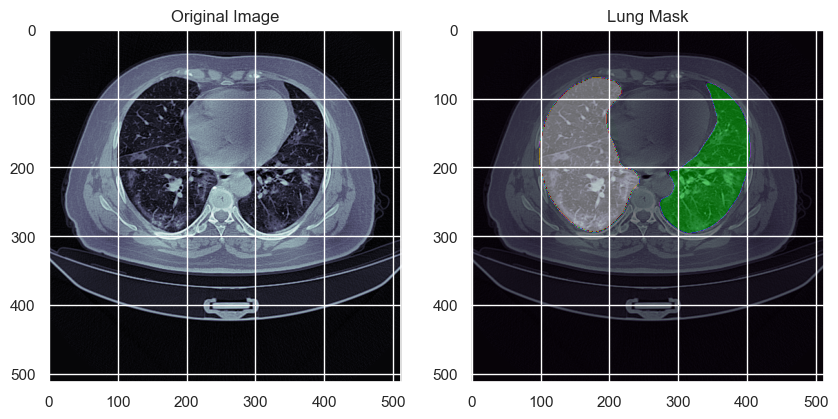

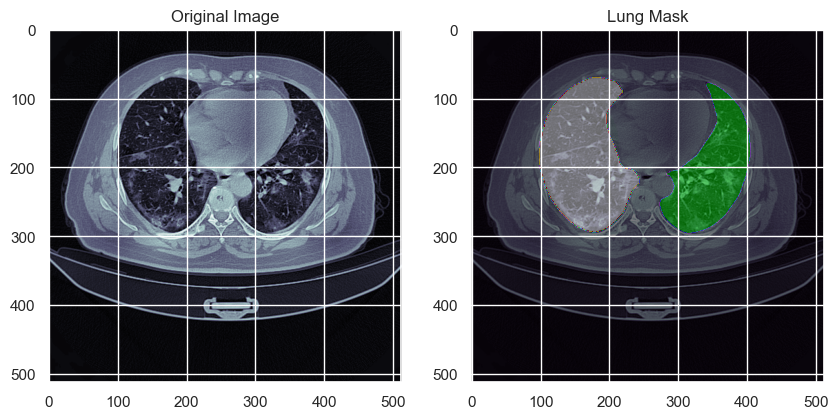

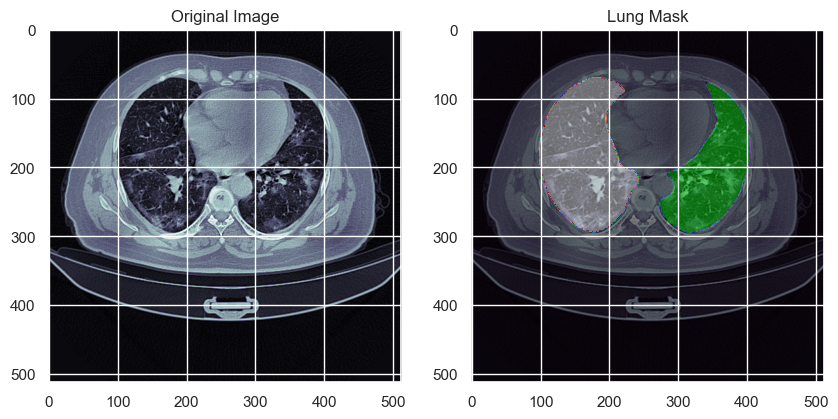

In [43]:
x = [99, 100, 101,102,103,104]
for index in x:
    plot_sample([new_cts[index], new_lungs[index]])

In [44]:
gc.collect()

40702

Text(0.5, 1.0, 'Final preprocessed corresponding image')

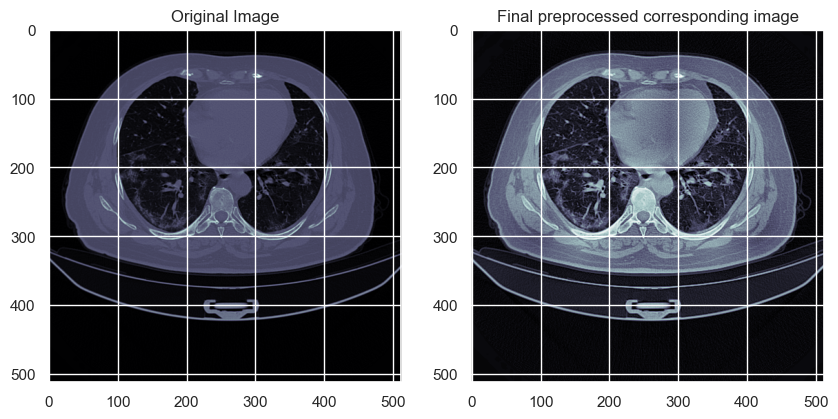

In [45]:
x = 100

rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(cts[x], cmap='bone')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(new_cts[x], cmap='bone')
plt.title("Final preprocessed corresponding image")

## Preparing data for Training and Testing

* Finally samples which will later be split into train and test, first we need to augment the data so it's in the right dtype and shape for us to process.

* Also, since we copped the images and masks, all cannot be of same size, so again a dimension needs to be decided to which all could be resized to. 
* Used median of the all width and height but couldn't fit the RAM so reduced the size to 224, though images with larger resolution with more clear features will possibly give better results on the same model.

In [46]:
dim1=[]
dim2=[]
for i in range(0, len(cts)):
    dim1.append(cts[i].shape[0])
    dim2.append(cts[i].shape[1])
dim1 = np.array(dim1)
dim2 = np.array(dim2)

print("An idea about the new net dimension to which all must be resized to (some will increase and some decrease) --->\nMedian", np.median(dim1),'x', np.median(dim2))
print("Max", np.max(dim1),'x', np.max(dim2))
print("Min", np.min(dim1),'x', np.min(dim2))

An idea about the new net dimension to which all must be resized to (some will increase and some decrease) --->
Median 512.0 x 512.0
Max 512 x 512
Min 512 x 512


In [47]:
# Used median of the all width and height but couldn't fit the RAM so reduced the size to 256, 
# though images with larger resolution with more clear features will possibly give better results on the same model.
# Lets take a look at these and images and see what we have
def dim_256(array, new_dim=256):
    '''
    Rescales image array to new dimentions to have all images be the same dimensions.
    This can help with issues of images being too large to process due to lack of RAM
    '''

    for i in range(0,len(array)):
        array[i] = cv2.resize(array[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
    array=np.array(array)
    array=np.uint8(array)
    return array

In [48]:
print('cts',type(new_cts),np.shape(new_cts))
print('lungs',type(new_lungs),np.shape(new_lungs))

cts <class 'list'> (2816, 512, 512)
lungs <class 'list'> (2816, 512, 512)


In [49]:
new_cts[0].dtype

dtype('uint8')

In [50]:
new_cts=dim_256(new_cts)
print(type(new_cts),np.shape(new_cts),new_cts.dtype)

<class 'numpy.ndarray'> (2816, 256, 256) uint8


In [51]:
new_lungs=dim_256(new_lungs)
print(type(new_lungs),np.shape(new_lungs), new_lungs.dtype)

<class 'numpy.ndarray'> (2816, 256, 256) uint8


In [52]:
print('cts',type(clean_cts),np.shape(clean_cts))
print('lungs',type(clean_lungs),np.shape(clean_lungs))

cts <class 'list'> (2816, 512, 512)
lungs <class 'list'> (2816, 512, 512)


In [53]:
new_clean_cts=dim_224(clean_cts)
print('new cleaned cts',type(new_clean_cts),np.shape(new_clean_cts), new_clean_cts.dtype)
new_clean_lungs=(dim_224(clean_lungs))
print('new cleained lungs',type(new_clean_lungs),np.shape(new_clean_lungs), new_clean_lungs.dtype)

new cleaned cts <class 'numpy.ndarray'> (2816, 256, 256) uint8
new cleained lungs <class 'numpy.ndarray'> (2816, 256, 256) uint8


In [54]:
new_mask_cts=dim_224(mask_cts)
print('new mask cts',type(new_mask_cts),np.shape(new_mask_cts), new_mask_cts.dtype)
new_mask_lungs=(dim_224(mask_lungs))
print('new mask lungs',type(new_mask_lungs),np.shape(new_mask_lungs), new_mask_lungs.dtype)

new mask cts <class 'numpy.ndarray'> (2733, 256, 256) uint8
new mask lungs <class 'numpy.ndarray'> (2733, 256, 256) uint8


* changed the dimensions to 256x256 to save memory

## Data augmentation pipeline

This allows us to rotate the data and train on different orientations.  It does two things.  Firstly it expands our data source.  Secondly it lets the algorithm look at the data in many different orientations so to be better trained to these situations thus making it more robust.
* This was from Deadskull7's pipeline and unfortunately I couldn't get it to work for me.  Could be a version issue with iaa

In [ ]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [ ]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-40, 40), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
], random_order=True)

In [ ]:
no_of_aug_imgs = 50
random_indices = np.random.randint(0, new_cts.shape[0], size=no_of_aug_imgs)
sample_new_cts = new_cts[random_indices]
sample_new_lungs = new_lungs[random_indices]

In [ ]:
# sample_cts = np.floor(sample_cts)
# sample_inf = np.floor(sample_inf)
# sample_cts = np.uint64(sample_cts)
# sample_inf = np.uint64(sample_inf)

In [ ]:
new_cts_aug, new_lungs_aug = seq(images=sample_new_cts, 
                              segmentation_maps=sample_new_lungs)

In [ ]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=8)

cells1 = new_cts_aug[rand]
grid_image1 = np.hstack(cells1)
plt.imshow(grid_image1, cmap = 'bone')

In [ ]:
cells2 = new_lungs_aug[rand]
grid_image2 = np.hstack(cells2)
plt.imshow(grid_image2, cmap = 'bone')

In [ ]:
print(new_cts_aug.shape, new_lungs_aug.shape)

In [ ]:
# cts = np.concatenate((cts, cts_aug), axis=0)
# infections = np.concatenate((infections, infections_aug), axis = 0)
# np.random.shuffle(cts)
# np.random.shuffle(infections)
# print(cts.shape, infections.shape)

In [ ]:
new_cts_aug = new_cts_aug/255
new_lungs_aug = new_lungs_aug/255
new_cts_aug = new_cts_aug.reshape(len(new_cts_aug), new_dim, new_dim, 1)
new_lungs_aug = new_lungs_aug.reshape(len(new_lungs_aug), new_dim, new_dim, 1)

## Saving Files

In [55]:
joblib.dump(cts, '../output/cts_256.pkl')
print('Saving cts files')
joblib.dump(lungs,'../output/lungs_256.pkl')
print('Saving lung files')

Saving cts files
Saving lung files


In [56]:
joblib.dump(clean_cts, '../output/cleaned_cts_256.pkl')
print('Saving cleaned cts files')
joblib.dump(clean_lungs,'../output/cleaned_lungs_256.pkl')
print('Saving cleaned lung files')

Saving cleaned cts files
Saving cleaned lung files


In [57]:
joblib.dump(new_mask_cts, '../output/mask_cts_256.pkl')
print('Saving mask cts files')
joblib.dump(new_mask_lungs,'../output/mask_lungs_256.pkl')
print('Saving mask lung files')

Saving mask cts files
Saving mask lung files


In [58]:
gc.collect()

46

## Training Testing Splitting

In [68]:
# To process the data in our CNN we need the data to be (stack, 256, 256, 1)
new_dim=256
train_cts = new_cts.reshape(len(new_cts), new_dim, new_dim, 1)
train_lungs = new_lungs.reshape(len(new_lungs), new_dim, new_dim, 1)

In [69]:
# We'll do the same with the cleaned version of the data which also has the images w/o lungs to train on.
new_dim=256
train_clean_cts = new_clean_cts.reshape(len(new_clean_cts), new_dim, new_dim, 1)
train_clean_lungs = new_clean_lungs.reshape(len(new_clean_lungs), new_dim, new_dim, 1)

In [70]:
x=train_cts # CLAHE enhanced cropped lung data for training
y=train_lungs # lung mask for testing

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=42) # random_state used for reproducibility
print('x shape:', x_train.shape, x_train.dtype, x_valid.shape, x_valid.dtype)
print('y shape', y_train.shape, y_train.dtype, y_valid.shape, y_valid.dtype)

x shape: (1971, 256, 256, 1) uint8 (845, 256, 256, 1) uint8
y shape (1971, 256, 256, 1) uint8 (845, 256, 256, 1) uint8


In [71]:
x2=train_clean_cts # CLAHE enhanced cropped lung data for training
y2=train_clean_lungs # infection mask for testing

x2_train, x2_valid, y2_train, y2_valid = train_test_split(x2, y2, test_size=0.3, random_state=42) # random_state used for reproducibility
print('x2 shape:', x2_train.shape, x2_valid.shape)
print('y2 shape', y2_train.shape, y_valid.shape)

x2 shape: (1971, 256, 256, 1) (845, 256, 256, 1)
y2 shape (1971, 256, 256, 1) (845, 256, 256, 1)


## Loss functions and metrics
* These dice coefficients and loss calculations were made by Deadskull7 for their answer to this.
* I do wonder if this is the source of my issues as I probably can use more standard dice and loss functions that are already in Keras

In [59]:
# Some preformance metrics
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

* All the hyperparameters are put in place after repeating trial and error for a fixed number of epochs.

In [60]:
from tensorflow import keras
from keras.callbacks import Callback
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D, Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D, MaxPooling3D, GlobalMaxPool3D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator #,img_to_array, array_to_img , load_img are supposed to be in this mix but I got errors
from keras import backend as K

In [61]:
new_dim=256

In [62]:
# Similar to deadskull7's but the layers are not connected liniarly. 
# This is faster on my machine and just about as accurate.
inputs = Input((new_dim, new_dim, 1)) #Makes a tensor for convolving
    
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = BatchNormalization()(x)  # Normalizes the data
x = MaxPooling2D((2, 2))(x)  # pulls the data by averageing a 2x2 block 
x = Dropout(0.25)(x)   # Drops out 25% of the connections randomly during training to prevent overfitting

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2)) (x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2)) (x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2)) (x)
x = Dropout(0.25)(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)

# At this point we start transposing the 2D convolution so we can translate it back into a image the same size as the original
x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)

x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)

x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)

x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (x) # Our output should be a mask of the lung the same dimension as the original image

model = Model(inputs=[inputs], outputs=[outputs], name='relu_model')
model.summary()

Model: "relu_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0

In [64]:
# Similar to deadskull7's but the layers are not connected liniarly. 
# This is faster on my machine and just about as accurate.
inputs = Input((new_dim, new_dim, 1)) #Makes a tensor for convolving
    
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
x = BatchNormalization()(x)  # Normalizes the data
x = MaxPooling2D((2, 2))(x)  # pulls the data by averageing a 2x2 block 
x = Dropout(0.25)(x)   # Drops out 25% of the connections randomly during training to prevent overfitting

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2)) (x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2)) (x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2)) (x)
x = Dropout(0.25)(x)


# At this point we start transposing the 2D convolution so we can translate it back into a image the same size as the original
x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)

x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)

x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)

x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (x) # Our output should be a mask of the lung the same dimension as the original image

model2 = Model(inputs=[inputs], outputs=[outputs], name='reduced_deadskull7_method')
model2.summary()

Model: "reduced_deadskull7_method"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_8 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 

## Compiling models

### Deadskull7's Call Back methods

* Some callbacks (model checkpointing with least validation loss, highest validation dice coefficient, learning rate reduction after some patience number of epochs)
* Also experimented with exponential decaying learning rate but found ReduceLROnPlateau a bit effective in this case.

In [74]:
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    This will start with a high learning rate and rapidly lower it before ramping it back up again.
    By doing this we can retest good weights that were lost when the learning rate was changed.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=1):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        print('\nEpoch %05d: CosineAnnealingScheduler setting learning ''rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [75]:
cosine_annealer = CosineAnnealingScheduler(T_max=7, eta_max=0.005, eta_min=0.001)

In [86]:
batch_size = 16 #reduced from original 32 because of memory issues
epochs = 60 #Reduced from 60 because in previous runs improvement stopped around there.
#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=7, verbose=1)
filepath_dice_coeff="unet_covid_weights_dice_coeff_lung.hdf5"
filepath_loss = "unet_covid_weights_val_loss_lung.hdf5"
checkpoint_dice = ModelCheckpoint(filepath_dice_coeff, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [87]:
gc.collect()

5914

In [88]:
model.compile(optimizer=Adam(learning_rate = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])
results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss],
                    use_multiprocessing=True)

Epoch 1/60


TypeError: in user code:

    File "C:\ProgramData\Anaconda3\envs\Covid_19_X_Rays\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_35296\669441436.py", line 16, in bce_dice_loss  *
        loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_35296\669441436.py", line 11, in dice_loss  *
        loss = 1 - dice_coeff(y_true, y_pred)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_35296\669441436.py", line 6, in dice_coeff  *
        intersection = K.sum(y_true_f * y_pred_f)

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type uint8 of argument 'x'.


In [89]:
# Maybe the issue is the data needs to be floating point 32 bit data and not uint 8 bit?
xf=np.float32(train_cts) # CLAHE enhanced cropped lung data for training
yf=np.float32(train_lungs) # lung mask for testing

xf_train, xf_valid, yf_train, yf_valid = train_test_split(xf, yf, test_size=0.3, random_state=42) # random_state used for reproducibility
print('xf shape:', xf_train.shape, xf_train.dtype, xf_valid.shape, xf_valid.dtype)
print('yf shape', yf_train.shape, yf_train.dtype, yf_valid.shape, yf_valid.dtype)

xf shape: (1971, 256, 256, 1) float32 (845, 256, 256, 1) float32
yf shape (1971, 256, 256, 1) float32 (845, 256, 256, 1) float32


In [90]:
model.compile(optimizer=Adam(learning_rate = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])
results = model.fit(xf_train, yf_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(xf_valid, yf_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss],
                    use_multiprocessing=True)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run TensorDataset: Dst tensor is not initialized. [Op:TensorDataset]

In [80]:
gc.collect()

76

In [ ]:
score = model.evaluate(xf_valid, yf_valid, batch_size=32)
print("test loss, test accuracy:", score)

* It ran but we are getting nan for loss and accuracy... that's not right either.

#### Training on the cleaned data

In [ ]:
results = model.fit(x2_train, y2_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x2_valid, y2_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss],
                    use_multiprocessing=True)

In [ ]:
gc.collect()

### Standard compile
* Since I couldn't get this to work on the lung data (I did on the infection data) I tried a different model compile

In [81]:
batch_size = 16 #reduced from original 32 because of memory issues
epochs = 60 #Reduced from 60 because in previous runs improvement stopped around there.
#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=7, verbose=1) # adjustable learning rate (not tried yet)

In [82]:
model2.compile(
    optimizer=Adam(learning_rate = 0.0005), 
    loss=keras.losses.CosineSimilarity(axis=1), 
    metrics=[
        keras.metrics.Accuracy(), 
        keras.metrics.AUC(),
    ]
)
results2 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    use_multiprocessing=True)

Epoch 1/60


TypeError: in user code:

    File "C:\ProgramData\Anaconda3\envs\Covid_19_X_Rays\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_35296\669441436.py", line 16, in bce_dice_loss  *
        loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_35296\669441436.py", line 11, in dice_loss  *
        loss = 1 - dice_coeff(y_true, y_pred)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_35296\669441436.py", line 6, in dice_coeff  *
        intersection = K.sum(y_true_f * y_pred_f)

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type uint8 of argument 'x'.


In [83]:
model2.compile(
    optimizer=Adam(learning_rate = 0.0005), 
    loss=keras.losses.CosineSimilarity(axis=1), 
    metrics=[
        keras.metrics.Accuracy(), 
        keras.metrics.AUC(),
    ]
)
results_floating2 = model.fit(xf_train, yf_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(xf_valid, yf_valid),
                    use_multiprocessing=True)

Epoch 1/60


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [ ]:
score = model2.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test accuracy:", score)

* That looks funny.
* lets use the same model on the cleaned up data and see if it's better?

In [ ]:
gc.collect()

In [ ]:
model2.compile(optimizer=Adam(learning_rate = 0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
results3 = model.fit(x2_train, y2_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x2_valid, y2_valid),
                    use_multiprocessing=True)

In [ ]:
score = model2.evaluate(x2_valid, y2_valid, batch_size=32)
print("test loss, test accuracy:", score)

## Saving the model we just created

In [ ]:
# Save weights as a .h5 file
model.save_weights('model_weights.h5')
print("Saving weights to disk")

In [ ]:
# Saving model as .h5 file
model.save('2D_Model.h5')
print("Saving model to disk")

## Validation

* Some actual vs predicted samples to check the performance of the model visually. Notice, how overlapping they are with each other, thus justifying the high dice coefficient.

In [ ]:
plt.rcParams["axes.grid"] = False

In [ ]:
def compare_actual_and_predicted(image_no, model):
    temp = model.predict(new_cts[image_no].reshape(1,new_dim, new_dim, 1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(new_cts[image_no].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(new_lungs[image_no].reshape(new_dim,new_dim), cmap='bone')
    plt.title('Actual mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(new_dim,new_dim), cmap='bone')
    plt.title('Predicted mask')

    plt.show()
    
# plt.imshow(temp.reshape(img_size, img_size), cmap = 'bone')
# plt.imshow(infections_scaled[120].reshape(img_size, img_size), cmap ='summer')

In [ ]:
for i in [440,269,555, 355, 380, 90]:
    compare_actual_and_predicted(i, model)

In [ ]:
gc.collect()

## What threshold has the best results?

In [ ]:
the_range = np.arange(0.10,0.80, 0.05)

In [ ]:
dices=[]
ious=[]

for t in the_range:
    iou = sm.metrics.IOUScore(threshold=t)
    dice = sm.metrics.FScore(threshold=t)
    model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
    score = model.evaluate(xf_valid, yf_valid, batch_size=32)
    dices.append(score[1])
    ious.append(score[2])

In [ ]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", the_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

In [ ]:
print("Best Threshold:", the_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [ ]:
rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])

In [ ]:
dices=[]
ious=[]
the_range = np.arange(0.05,0.80, 0.075)

for t in the_range:
    iou = sm.metrics.IOUScore(threshold=t)
    dice = sm.metrics.FScore(threshold=t)
    model_4.compile(optimizer=Adam(learning_rate = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
    score = model_4.evaluate(x_valid, y_valid, batch_size=16)
    dices.append(score[1])
    ious.append(score[2])

In [ ]:
gc.collect()

In [ ]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", the_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

In [ ]:
print("Best Threshold:", the_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [ ]:
gc.collect()

In [ ]:
the_prec_rec_range = np.arange(0,1, 0.1)
precisions=[]
recalls=[]

for t in the_prec_rec_range:
    precision = sm.metrics.Precision(threshold=t)
    recall = sm.metrics.Recall(threshold=t)
    model_4.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[precision, recall])
    score = model_4.evaluate(x_valid, y_valid, batch_size=16)
    precisions.append(score[1])
    recalls.append(score[2])

In [ ]:
print('PRECISIONS:',precisions)
print("RRECALLS:",recalls)
print("Best Threshold for Precision:", the_prec_rec_range[np.argmax(precisions)])
print("Best Threshold for Recall:", the_prec_rec_range[np.argmax(recalls)])
print("Best precision score:", precisions[np.argmax(precisions)])
print("Best recall score:", recalls[np.argmax(recalls)])

In [ ]:
fig = plt.figure(figsize=(7,7))
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds Lung Mask Model 4")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])
plt.show()
fig.savefig('../output/percision_and_recall_Lungs_model_4.png')

In [ ]:
gc.collect()

In [ ]:
# Saving model as .h5 file
model_4.save('Lung_Model4.h5')
print("Saving model 4 to disk")